# Extract geographical watershed properties automatically using PAVICS-Hydro's geospatial toolbox

Hydrological models typically need geographical information about watersheds being simulated: latitude and longitude, area, mean altitude, land-use, etc, and Raven is no exception. This notebook shows how to obtain this information using remote services that are made available for users on PAVICS. These services connect to a digital elevation model (DEM) and a land-use data set to extract relevant information.

The DEM used in the following is the [EarthEnv-DEM90](https://www.earthenv.org/DEM), while the land-use dataset is the [North American Land Change Monitoring System](http://www.cec.org/north-american-environmental-atlas/land-cover-30m-2015-landsat-and-rapideye/). Other data sources could be used, given they're available through the Web Coverage Service (WCS) protocol.

Since these computations happen on a specific Geoserver hosted on PAVICS, we first need to establish a connection to that service.

In [1]:
# We need to import a few packages required to do the work
import os

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rioxarray as rio  # noqa
from birdy import WPSClient

# This is the URL of the Geoserver that will perform the computations for us.
url = os.environ.get(
    "WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps"
)

# Connect to the PAVICS Raven WPS server
wps = WPSClient(url)

This notebook assumes that you have a watershed outline available. If not, look at this [notebook](https://ravenpy.readthedocs.io/en/latest/notebooks/01_Getting_watershed_boundaries.html) from the RavenPy documentation which explains how to get the countour of a watershed upstream from a point of interest. Let's first display the watershed outline using [GeoPandas](https://geopandas.org/en/stable/).

,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,LAKE,NEXT_DOWN,NEXT_SINK,ORDER,PFAF_ID,SIDE,SORT,SUB_AREA,UP_AREA,id,geometry
0,0,141.3,141.3,0,7120319552,0,7120319551,7120034330,1,724083033100,R,96044,56.2,73072.4,USGS_HydroBASINS_lake_na_lev12.96044,"POLYGON ((-71.4083 48.4417, -71.423 48.4422, -..."


<Axes: >

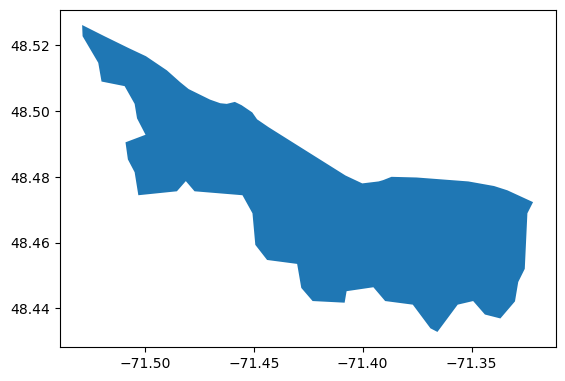

In [2]:
watershed = "tutorial_data/input.geojson"
df = gpd.read_file(watershed)
display(df)
df.plot()

## Generic watershed properties

Now that we have delineated a watershed, lets find the zonal statistics and other properties using the `shape_properties` process. This process requires a `shape` argument defining the watershed contour, the exterior polygon. The polygon can be given either as a link to a geometry file  (e.g. a geojson file such as `feature_url`), or as data embedded in a string. For example, if variable `feature` is a `GeoPandas` geometry, `json.dumps(feature)` can be used to convert it to a string and pass it as the `shape` argument.

Typically, we expect users will simply upload a shapefile and use this code to perform the extraction on the region of interest.

In [3]:
shape_resp = wps.shape_properties(shape=watershed)

Once the process has completed, we extract the data from the response, as follows. Note that you do not need to change anything here. The code will work and return the desired results.

In [4]:
(properties,) = shape_resp.get(asobj=True)
prop = properties[0]
display(prop)

area = prop["area"] / 1000000.0
longitude = prop["centroid"][0]
latitude = prop["centroid"][1]
gravelius = prop["gravelius"]
perimeter = prop["perimeter"]

shape_info = {
    "area": area,
    "longitude": longitude,
    "latitude": latitude,
    "gravelius": gravelius,
    "perimeter": perimeter,
}
display(shape_info)

{'id': 'USGS_HydroBASINS_lake_na_lev12.96044',
 'COAST': 0,
 'DIST_MAIN': 141.3,
 'DIST_SINK': 141.3,
 'ENDO': 0,
 'HYBAS_ID': 7120319552,
 'LAKE': 0,
 'NEXT_DOWN': 7120319551,
 'NEXT_SINK': 7120034330,
 'ORDER': 1,
 'PFAF_ID': 724083033100,
 'SIDE': 'R',
 'SORT': 96044,
 'SUB_AREA': 56.2,
 'UP_AREA': 73072.4,
 'area': 55919453.46888515,
 'centroid': [-71.41715786806483, 48.47239495054429],
 'perimeter': 45133.04400352313,
 'gravelius': 1.7025827715870572}

{'area': 55.91945346888515,
 'longitude': -71.41715786806483,
 'latitude': 48.47239495054429,
 'gravelius': 1.7025827715870572,
 'perimeter': 45133.04400352313}

Note that these properties are a mix of the properties of the original file where the shape is stored, and properties computed by the process (area, centroid, perimeter and gravelius). Note also that the computed area is in m², while the "SUB_AREA" property is in km², and that there are slight differences between the two values due to the precision of HydroSHEDS and the delineation algorithm.

## Land-use information

Now we extract the land-use properties of the watershed using the `nalcms_zonal_stats` process. As mentioned, it uses a dataset from the [North American Land Change Monitoring System](http://www.cec.org/north-american-environmental-atlas), and retrieve properties over the given region. 

With the `nalcms_zonal_stats_raster` process, we also return the raster grid itself. Note that this is a high-resolution dataset, and to avoid taxing the system's resource, requests are limited to areas under 100,000km². 

In [5]:
stats_resp = wps.nalcms_zonal_stats_raster(
    shape=watershed, select_all_touching=True, band=1, simple_categories=True
)

Here we will get the raster data and show it as a grid. Here the `birdy` client automatically transforms the returned `geotiff` file to a `DataArray` using either `gdal`, `rasterio`, or `rioxarray`, depending on what libraries are available in our runtime environment. Note that `pymetalink` needs to be installed for this to work. 

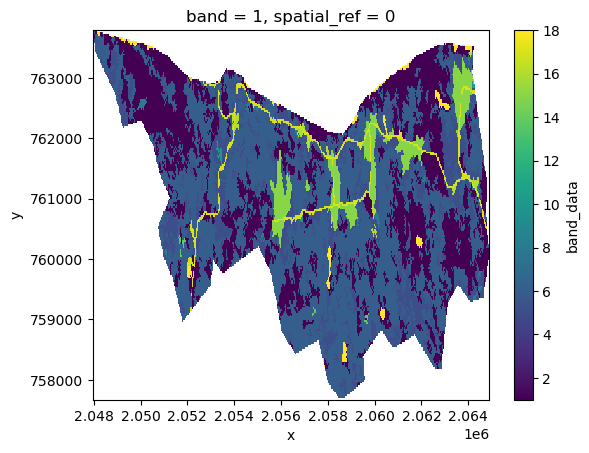

In [6]:
features, statistics, raster = stats_resp.get(asobj=True)
grid = raster[0]
grid.plot()

From there, it's easy to calculate the ratio and percentages of each land-use component. This code should also be left as-is unless you really know what you are doing.

In [7]:
lu = statistics[0]
total = sum(lu.values())

land_use = {k: (v / total) for (k, v) in lu.items()}
display("Land use ratios", land_use)

land_use_pct = {k: f"{np.round(v/total*100, 2)} %" for (k, v) in lu.items()}
display("Land use percentages", land_use_pct)

'Land use ratios'

{'Ocean': 0.0,
 'Forest': 0.9095753879046077,
 'Shrubs': 0.004920532612284039,
 'Grass': 0.005753721840562167,
 'Wetland': 0.0009589536400936945,
 'Crops': 0.045605319834619795,
 'Urban': 0.02361226831837261,
 'Water': 0.009573815849459998,
 'SnowIce': 0.0}

'Land use percentages'

{'Ocean': '0.0 %',
 'Forest': '90.96 %',
 'Shrubs': '0.49 %',
 'Grass': '0.58 %',
 'Wetland': '0.1 %',
 'Crops': '4.56 %',
 'Urban': '2.36 %',
 'Water': '0.96 %',
 'SnowIce': '0.0 %'}

### Display the land-use statistics
Here we can display the land-use statistics according to the land cover map, as a function of land cover raster pixels over the catchment. Again, this does not need to be modified at all. It can also be simply deleted if the visualization tools are not required for your use-case.

The land-use categories available are: [ 1.  5.  6.  8. 10. 14. 15. 16. 17. 18. nan]
The number of occurrences of each land-use category is: [18949  9163 29747   313    72    61  2901   294  1502   609 51649]


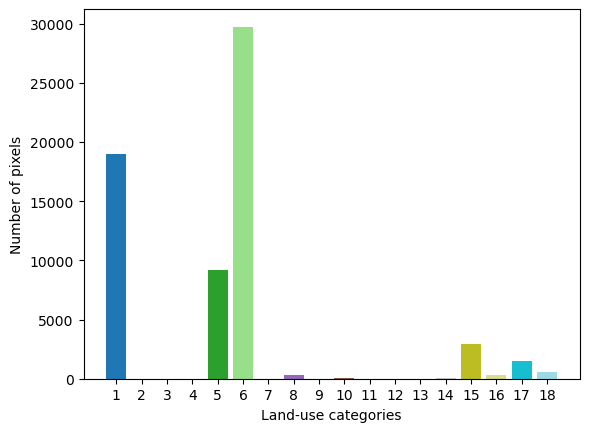

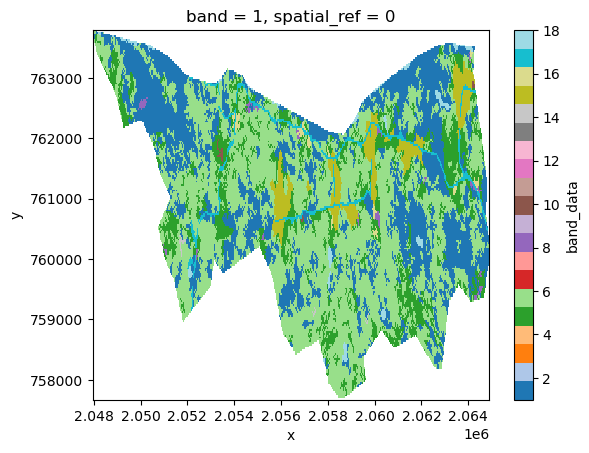

In [8]:
unique, counts = np.unique(grid, return_counts=True)
print("The land-use categories available are: " + str(unique))
print("The number of occurrences of each land-use category is: " + str(counts))

# Pixels values at '127' are NaN and can be ignored.
from matplotlib.colors import Normalize

norm = Normalize()
norm.autoscale(unique[:-1])
cm = mpl.colormaps["tab20"]
plt.bar(unique[:-1], counts[:-1], color=cm(norm(unique[:-1])))


# plt.bar(unique[:-1], counts[:-1])
plt.xticks(np.arange(min(unique[:-1]), max(unique[:-1]) + 1, 1.0))
plt.xlabel("Land-use categories")
plt.ylabel("Number of pixels")
plt.show()

grid.where(grid != 127).sel(band=1).plot.imshow(cmap="tab20")
grid.name = "Land-use categories"
plt.show()

These values are not very helpful on their own, so the following relationship will be helpful to map the grid to specific land-uses. We can see from this example that we have mostly "Temperate or sub-polar needleaf forest" with some "Sub-polar taiga needleleaf forest" and a bit of "Temperate or sub-polar boardleaf deciduous forest". Exact percentages can be computed from the array of values as extracted and displayed above.

- 0: Ocean
- 1: Temperate or sub-polar needleleaf forest
- 2: Sub-polar taiga needleleaf forest
- 3: Tropical or sub-tropical broadleaf evergreen forest
- 4: Tropical or sub-tropical broadleaf deciduous forest
- 5: Temperate or sub-polar broadleaf deciduous forest
- 6: Mixed forest
- 7: Tropical or sub-tropical shrubland
- 8: Temperate or sub-polar shrubland
- 9: Tropical or sub-tropical grassland
- 10: Temperate or sub-polar grassland
- 11: Sub-polar or polar shrubland-lichen-moss
- 12: Sub-polar or polar grassland-lichen-moss
- 13: Sub-polar or polar barren-lichen-moss
- 14: Wetland
- 15: Cropland
- 16: Barren lands
- 17: Urban
- 18: Water
- 19: Snow and Ice


Since the GeoTiff object was opened as an `xarray.Dataset` with the `.open_rasterio()` method, this makes it very easy to spatially reproject it with the `cartopy` library. Here we provide a sample projection, but this would need to be adapted to your needs.

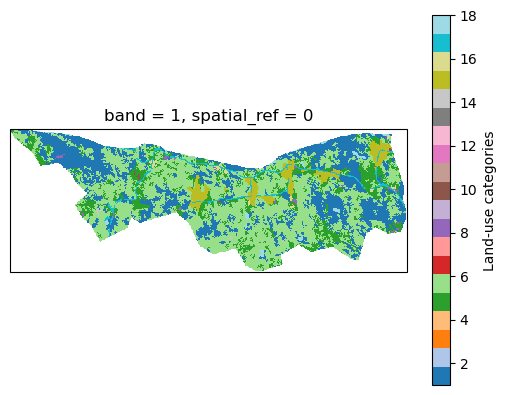

In [9]:
import cartopy.crs as ccrs

# Set a CRS transformation:
crs = ccrs.LambertConformal(
    central_latitude=49, central_longitude=-95, standard_parallels=(49, 77)
)

ax = plt.subplot(projection=crs)
grid.name = "Land-use categories"
grid.where(grid != 127).sel(band=1).plot.imshow(ax=ax, transform=crs, cmap="tab20")
plt.show()

## Terrain information from the DEM

Here we collect terrain data, such as elevation, slope and aspect, from the DEM. We will do this using the `terrain_analysis` WPS service, which by default uses DEM data from [EarthEnv-DEM90](https://www.earthenv.org/DEM).

Note here that while the feature outline is defined above in terms of geographic coordinates (latitude, longitude), the DEM is projected onto a 2D cartesian coordinate system (here NAD83, the Canada Atlas Lambert projection). This is necessary to perform slope calculations. For more information on this, see: https://en.wikipedia.org/wiki/Map_projection

The DEM data returned in the process response here shows `rioxarray`-like access but using the URLs we can open the files however we like.

In [10]:
terrain_resp = wps.terrain_analysis(
    shape=watershed, select_all_touching=True, projected_crs=3978
)

In [11]:
# NBVAL_IGNORE_OUTPUT

properties, dem = terrain_resp.get(asobj=True)
elevation = properties[0]["elevation"]
slope = properties[0]["slope"]
aspect = properties[0]["aspect"]

terrain = {"elevation": elevation, "slope": slope, "aspect": aspect}
display(terrain)

{'elevation': 165.37033101757254,
 'slope': 3.8477161303214786,
 'aspect': 5.4659402646877995}

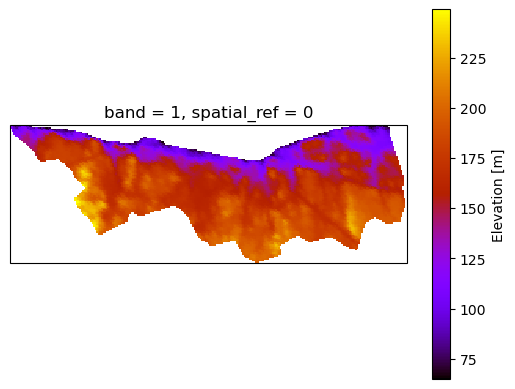

In [12]:
crs = ccrs.LambertConformal(
    central_latitude=49, central_longitude=-95, standard_parallels=(49, 77)
)

dem.name = "Elevation"
dem.attrs["units"] = "m"
ax = plt.subplot(projection=crs)
dem.where(dem != -32768).sel(band=1).plot.imshow(ax=ax, transform=crs, cmap="gnuplot")
plt.show()

In [13]:
# We can also access the files directly via their URLs:
properties, dem = terrain_resp.get(asobj=False)
display(properties, dem)

# Let's read the data from band=1 as numpy array
display(rasterio.open(dem).read(1))

'https://pavics.ouranos.ca/wpsoutputs/raven/0da6ce44-68c0-11f0-ad60-0242ac13000d/input.json'

'https://pavics.ouranos.ca/wpsoutputs/raven/0da6ce44-68c0-11f0-ad60-0242ac13000d/clipped_376drw4u.tiff'

array([[-32768, -32768,     86, ..., -32768, -32768, -32768],
       [   120,    103,     86, ..., -32768, -32768, -32768],
       [   120,    104,     93, ..., -32768, -32768, -32768],
       ...,
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768]],
      shape=(88, 253), dtype=int16)

## Overview

A synthesis of all watershed properties can be created by merging the various dictionaries created. This allows users to easily access any of these values, and to provide them to Raven as needed.

In [14]:
# NBVAL_IGNORE_OUTPUT

all_properties = {**shape_info, **land_use, **terrain}
display(all_properties)

{'area': 55.91945346888515,
 'longitude': -71.41715786806483,
 'latitude': 48.47239495054429,
 'gravelius': 1.7025827715870572,
 'perimeter': 45133.04400352313,
 'Ocean': 0.0,
 'Forest': 0.9095753879046077,
 'Shrubs': 0.004920532612284039,
 'Grass': 0.005753721840562167,
 'Wetland': 0.0009589536400936945,
 'Crops': 0.045605319834619795,
 'Urban': 0.02361226831837261,
 'Water': 0.009573815849459998,
 'SnowIce': 0.0,
 'elevation': 165.37033101757254,
 'slope': 3.8477161303214786,
 'aspect': 5.4659402646877995}